# Citibike Data : First Steps and Analysis


In [59]:
import pandas as pd
import numpy as np
import googlemaps
import config

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot') 

gmaps = googlemaps.Client(key=config.gmaps_api_key)

In [79]:
# Read text file into pandas. By observation, use new line as separator declare no header so first line is read as data.
trips_df = pd.read_csv('trips.txt', sep="\n", header=None)

# Convert df from number_of_trips*5 by 1 to number_of_trips by 5
trips_df = (pd.DataFrame(np.reshape(trips_df.values,(round(len(trips_df)/5), 5)), 
                         columns=['start_time','start_loc','end_time','end_loc','duration']))

# Convert strings of times to datetimes
trips_df[['start_time','end_time']] = trips_df[['start_time','end_time']].apply(pd.to_datetime)

# Replace imported duration time with datetime calculated from start and end times.
trips_df['duration'] = trips_df['end_time'] - trips_df['start_time']

trips_df.head()

,start_time,start_loc,end_time,end_loc,duration
0,2018-04-28 14:24:58,Bond St & Fulton St,2018-04-28 15:12:36,11 St & 35 Ave,00:47:38
1,2018-04-24 08:09:43,1 Ave & E 68 St,2018-04-24 08:29:39,E 19 St & 3 Ave,00:19:56
2,2018-04-23 08:20:09,Bond St & Fulton St,2018-04-23 08:46:25,E 19 St & 3 Ave,00:26:16
3,2018-04-18 17:55:20,E 19 St & 3 Ave,2018-04-18 18:25:50,Bond St & Fulton St,00:30:30
4,2018-04-14 18:35:31,Central Park West & W 85 St,2018-04-14 18:47:31,E 71 St & 1 Ave,00:12:00


In [80]:
# Count number of trips that start and end at same station. For these trips, assume no meaningful travel. Sum durations for later reporting.
non_trips = sum(trips_df['start_loc'] == trips_df['end_loc'])
non_trips_time = trips_df[trips_df['start_loc'] == trips_df['end_loc']]['duration'].sum()

# Drop these trips, reset index.
trips_df.drop(trips_df[trips_df['start_loc'] == trips_df['end_loc']].index, inplace = True)
trips_df.reset_index(inplace = True, drop = True)

# Append city and state to locations to avoid ambiguity.

trips_df[['start_loc','end_loc']] = trips_df[['start_loc','end_loc']].astype(str) + ", New York, NY"

In [81]:
trips_df.head()

,start_time,start_loc,end_time,end_loc,duration
0,2018-04-28 14:24:58,"Bond St & Fulton St, New York, NY",2018-04-28 15:12:36,"11 St & 35 Ave, New York, NY",00:47:38
1,2018-04-24 08:09:43,"1 Ave & E 68 St, New York, NY",2018-04-24 08:29:39,"E 19 St & 3 Ave, New York, NY",00:19:56
2,2018-04-23 08:20:09,"Bond St & Fulton St, New York, NY",2018-04-23 08:46:25,"E 19 St & 3 Ave, New York, NY",00:26:16
3,2018-04-18 17:55:20,"E 19 St & 3 Ave, New York, NY",2018-04-18 18:25:50,"Bond St & Fulton St, New York, NY",00:30:30
4,2018-04-14 18:35:31,"Central Park West & W 85 St, New York, NY",2018-04-14 18:47:31,"E 71 St & 1 Ave, New York, NY",00:12:00


In [5]:
# Group and count rows where start_loc and end_loc have the same values. Reset index and rename column to be count.
# Create a unique df so as to minimize the number of hits on the Google Maps API.

unique = trips_df.groupby(['start_loc','end_loc']).size().reset_index().rename(columns= {0:'count'})
unique.head()

,start_loc,end_loc,count
0,"1 Ave & E 16 St, New York, NY","Duffield St & Willoughby St, New York, NY",1
1,"1 Ave & E 68 St, New York, NY","E 17 St & Broadway, New York, NY",1
2,"1 Ave & E 68 St, New York, NY","E 19 St & 3 Ave, New York, NY",14
3,"1 Ave & E 68 St, New York, NY","E 20 St & Park Ave, New York, NY",2
4,"1 Ave & E 68 St, New York, NY","E 44 St & 2 Ave, New York, NY",1


In [6]:
# Define function that will use Google Maps API to retrieve assumed routes for all unique trips.

def get_bike_directions(row):
    origin = row['start_loc']
    destination = row['end_loc']
    mode = "bicycling"
    return gmaps.directions(origin, destination, mode)

directions = unique.apply(get_bike_directions, axis = 1)

In [9]:
unique['directions'] = directions

In [10]:
# Parse returned JSON to extract overall distance and overall duration of route.

unique['dist'] = unique['directions'].apply(lambda x : x[0]["legs"][0]['distance']['text'])
unique['google_time'] = unique['directions'].apply(lambda x : x[0]["legs"][0]['duration']['text'])

In [63]:
unique.head()

,start_loc,end_loc,count,directions,dist,google_time
0,"1 Ave & E 16 St, New York, NY","Duffield St & Willoughby St, New York, NY",1,"[{'bounds': {'northeast': {'lat': 40.7333362, ...",3.6 mi,22 mins
1,"1 Ave & E 68 St, New York, NY","E 17 St & Broadway, New York, NY",1,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",3.5 mi,20 mins
2,"1 Ave & E 68 St, New York, NY","E 19 St & 3 Ave, New York, NY",14,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",3.1 mi,17 mins
3,"1 Ave & E 68 St, New York, NY","E 20 St & Park Ave, New York, NY",2,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",3.5 mi,20 mins
4,"1 Ave & E 68 St, New York, NY","E 44 St & 2 Ave, New York, NY",1,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",1.8 mi,10 mins


In [82]:
trips_df = pd.merge(trips_df, unique, how='left', left_on=['start_loc','end_loc'], right_on=['start_loc','end_loc']).drop(['count'], axis =1)

In [83]:
trips_df['dist'] = trips_df['dist'].apply(lambda x : x[:-3])

In [84]:
trips_df = trips_df.rename(columns={'dist':'dist_miles'})

In [85]:
trips_df['speed_mph'] = trips_df['dist_miles'].astype(float) / (trips_df['duration']/np.timedelta64(1, 'h'))

In [86]:
trips_df.head()

,start_time,start_loc,end_time,end_loc,duration,directions,dist_miles,google_time,speed_mph
0,2018-04-28 14:24:58,"Bond St & Fulton St, New York, NY",2018-04-28 15:12:36,"11 St & 35 Ave, New York, NY",00:47:38,"[{'bounds': {'northeast': {'lat': 40.7628454, ...",7.5,43 mins,9.447166
1,2018-04-24 08:09:43,"1 Ave & E 68 St, New York, NY",2018-04-24 08:29:39,"E 19 St & 3 Ave, New York, NY",00:19:56,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",3.1,17 mins,9.331104
2,2018-04-23 08:20:09,"Bond St & Fulton St, New York, NY",2018-04-23 08:46:25,"E 19 St & 3 Ave, New York, NY",00:26:16,"[{'bounds': {'northeast': {'lat': 40.7363809, ...",4.2,25 mins,9.593909
3,2018-04-18 17:55:20,"E 19 St & 3 Ave, New York, NY",2018-04-18 18:25:50,"Bond St & Fulton St, New York, NY",00:30:30,"[{'bounds': {'northeast': {'lat': 40.736971, '...",4.0,23 mins,7.868852
4,2018-04-14 18:35:31,"Central Park West & W 85 St, New York, NY",2018-04-14 18:47:31,"E 71 St & 1 Ave, New York, NY",00:12:00,"[{'bounds': {'northeast': {'lat': 40.784612, '...",3.1,20 mins,15.500000


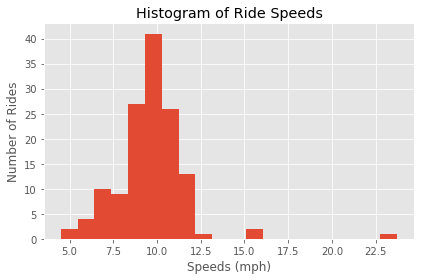

In [87]:
num_bins = 20
fig, ax = plt.subplots()

ax.hist(trips_df['speed_mph'], bins=num_bins)
ax.set_xlabel('Speeds (mph)')
ax.set_ylabel('Number of Rides')
ax.set_title('Histogram of Ride Speeds')

fig.tight_layout()
plt.show()

In [88]:
# Based on histogram above, assume that rides over 20 mph are erroneous -- i.e., I took a shortcut down a one-way compared
# to what Google suggested, or, for the > 20 mph ride, the address/pathfinding is wrong because of Brooklyn vs NY, NY.
trips_df = trips_df.drop(trips_df[trips_df.speed_mph > 12].index)

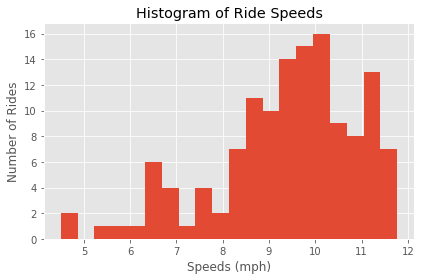

In [95]:
num_bins = 20
fig, ax = plt.subplots()

ax.hist(trips_df['speed_mph'], bins=num_bins)
ax.set_xlabel('Speeds (mph)')
ax.set_ylabel('Number of Rides')
ax.set_title('Histogram of Ride Speeds')

fig.tight_layout()
plt.show()

AttributeError: Unknown property bins

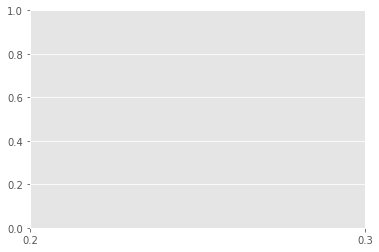

In [98]:
fig, ax = plt.subplots()

ax.scatter(x = trips_df['dist_miles'], y = trips_df['speed_mph'], marker = 'o', bins=10)
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Speed (mph)')
ax.set_title('Ride Speed vs. Distance')

plt.show()